In [1]:
#IMPORTING LIBRARIES
# !pip install Keras
import numpy as np
import pandas as pd 
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shutil

import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Using TensorFlow backend.


In [2]:
#SETTING HYPERPARAMETERS FOR THE IMAGE
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB

In [3]:
#SPLITTING NAME OF IMAGES TO DISTINGUISH CATS AND DOGS
path = r'C:\Users\RapidTurtle\Desktop\python project\train\\'
filenames = os.listdir(path) # list of images in the folder
categories = [] # list to classify images for training
for filename in filenames:
    category = filename.split('.')[0] # .split('.') - splitting file's name and taking only 1 character to represent cat/dog
    if category == 'dog': # if it's a dog add 1
        categories.append(1)
    else: # if it's a cat add 0
        categories.append(0)
        
df = pd.DataFrame({ # creating a table
    'filename': filenames, # filename - image name
    'category': categories # category - 1(dog) / 0(cat) 
})

In [4]:
df.head() # start of table

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail() # end of the table

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


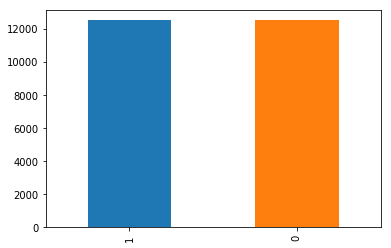

In [6]:
df['category'].value_counts().plot.bar() # represent the data graphically

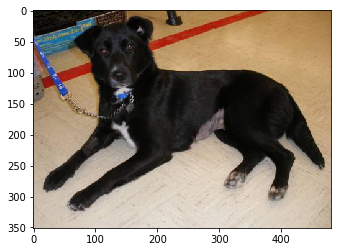

In [7]:
#SHOW A RANDOM IMAGE FROM THE SET
sample = random.choice(filenames) 
image = load_img(path + "\\" +  sample)
plt.imshow(image)

In [8]:
#CREATING A SEQUENTIAL MODEL USING KERAS
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# 32 - filters, (3, 3) - filter core, activation='relu' - activation function, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) - input data
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #chooses pixels with highest values and compresses the image
model.add(Dropout(0.25)) # function is disable for some neurons to not overtrain

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(512, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary() # number of layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
#EarlyStopping() - Will stop learnign when quality will stop improving.
#patience=10 - after how many epochs without quality increase it will stop

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#ReduceLROnPlateau() - Reduce level of learning when rate stop increasing
callbacks = [earlystop, learning_rate_reduction]

In [10]:
#TO SPLIT TRAINING DATA INTO DATA FOR TRAINING AND VALIDATING
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

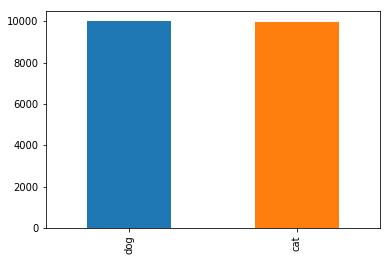

In [11]:
train_df['category'].value_counts().plot.bar()

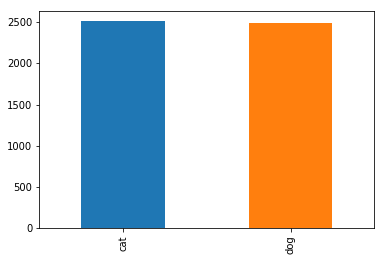

In [12]:
validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [14]:
#Image processing for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
#Image processing for validating
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
#Start of learning
epochs=3
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 1299s 975ms/step - loss: 0.7447 - acc: 0.6316 - val_loss: 0.5891 - val_acc: 0.6925
Epoch 2/3
1333/1333 [==============================] - 1038s 778ms/step - loss: 0.5531 - acc: 0.7251 - val_loss: 0.5421 - val_acc: 0.7366
Epoch 3/3
1333/1333 [==============================] - 1163s 873ms/step - loss: 0.5039 - acc: 0.7597 - val_loss: 0.4265 - val_acc: 0.8072


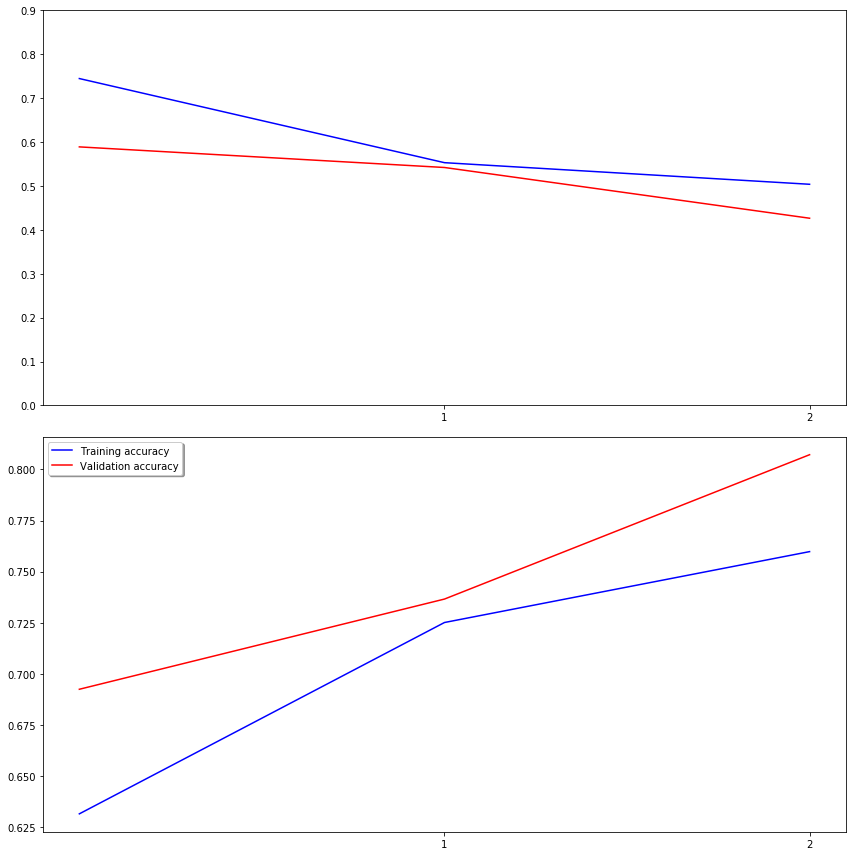

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [18]:
model.save_weights("model.h5")

In [ ]:
#model = keras.models.load_model(r'C:\Users\RapidTurtle\Desktop\python project\catdog2(1).h5')

In [20]:
test_filenames = os.listdir(r"C:\Users\RapidTurtle\Desktop\python project\test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)
print(batch_size)
print(np.ceil(nb_samples/batch_size))

12500
15
834.0


In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\RapidTurtle\Desktop\python project\test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size, 
    shuffle=False
)

Found 12500 validated image filenames.


In [23]:
predict = model.predict_generator(test_generator, steps=150)

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\Users\RapidTurtle\Desktop\python project\test1"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
#function to load image and see the result
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

classification = ['cat', 'dog']

def predict_img(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    plt.imshow(img_tensor[0])
    plt.show()
    
    
    prediction = model.predict(img_tensor)
    print(prediction)
    top = np.argmax(prediction)
    print(classification[top])
    

file = 'images.jpg'
predict_img(r'C:\Users\RapidTurtle\Desktop\python project\\' + file)